# Modelling Exploration Notebook
- Latent dirichlet allocation
- Text Classification into fixed categories
- Embed text and build clusers form the embedding space

# DeepAR

## Experiments

In [ ]:
# !pip install sqlalchemy

In [3]:
from sqlalchemy import create_engine, Column, Integer, Float, String, ForeignKey, select
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker, relationship

In [4]:
Base = declarative_base()

class Forecast_Experiment(Base):
    __tablename__ = 'forecast_experiment'
    id = Column('id', Integer, primary_key=True)
    model = Column('model name', String(20))
    target = Column('target', String(100))
    past_rts_col = Column('past_rts_col', String(1000))
    epochs = Column('epochs', Integer)
    prediction_length = Column('prediction_length', Integer)
    num_layers = Column('num_layers', Integer)
    hidden_size = Column('hidden_size', Integer)
    MASE = Column('MASE', Float)
    MAPE = Column('MAPE', Float)
    RMSE = Column('RMSE', Float)
    wQL_10 = Column('wQL_01', Float)
    wQL_50 = Column('wQL_50', Float)
    wQL_90 = Column('wQL_90', Float)
    avg_wQL = Column('avg_wQL', Float)

<ipython-input-4-9eca5a238d76>:1: MovedIn20Warning: The ``declarative_base()`` function is now available as sqlalchemy.orm.declarative_base(). (deprecated since: 2.0) (Background on SQLAlchemy 2.0 at: https://sqlalche.me/e/b8d9)
  Base = declarative_base()


In [5]:
# engine = create_engine('sqlite:///:memory:', echo=True)
engine = create_engine("sqlite:///./config/forecast_config.db")

Base.metadata.create_all(bind=engine)
Session = sessionmaker(bind=engine)
session = Session()

In [13]:
q1 = select(Forecast_Experiment)
q1_result = session.execute(q1) 
for s in q1_result.scalars():
    print(f"{s.model}: (e{s.epochs}, l{s.num_layers}, n{s.hidden_size}) \n   avg_wQL = {s.avg_wQL}")

torch_deepar: (e10, l2, n40) 
   avg_wQL = 0.15815992665967143
torch_deepar: (e200, l2, n40) 
   avg_wQL = 0.06275540445735626
torch_deepar: (e400, l2, n40) 
   avg_wQL = 0.05386742979053971


## DeepAR Modelling

In [3]:
# !pip install "gluonts[torch]"

In [4]:
# import deepar experiment method
from src.deepar_script import run_deepar_experiment
import matplotlib.pyplot as plt
import json

/opt/conda/lib/python3.9/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Data specs
input_paths = [
    "../data_engineering/financial_ts/indices.csv",
    "../data_engineering/financial_ts/ww_gdp.csv",
    "../data_engineering/timeseries_data/ts_dgelt_events.csv"
]
target_col = 'ts_MSCI_World'
with open('./config/past_rts_cols.json', 'r') as fp:
    past_rts_col = json.load(fp)['version_1']

# Model specs
prediction_length=56
num_layers=4
hidden_size=40
max_epochs = 1

# Hardware specs
accelerator = "gpu"
devices = -1

In [6]:
forecasts, tss, agg_metrics = run_deepar_experiment(
    input_paths=input_paths,
    target_col=target_col,
    past_rts_col=past_rts_col,
    prediction_length=prediction_length,
    num_layers=num_layers,
    hidden_size=hidden_size,
    max_epochs=max_epochs,
    accelerator=accelerator,
    devices=devices
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
/opt/conda/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:72: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(


AssertionError: Torch not compiled with CUDA enabled

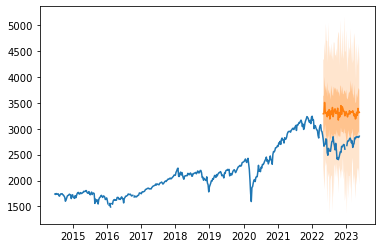

In [5]:
for ts, forecast in zip(tss, forecasts):
    plt.plot(ts.to_timestamp())
    forecast.plot()

In [6]:
experiment_config = Forecast_Experiment(
    model = 'torch_deepar',
    target = target_col,
    past_rts_col = str(past_rts_col),
    epochs = max_epochs,
    prediction_length = prediction_length,
    num_layers = num_layers,
    hidden_size = hidden_size,
    MASE = agg_metrics['MASE'],
    MAPE = agg_metrics['MAPE'],
    RMSE = agg_metrics['RMSE'],
    wQL_10 = agg_metrics['wQuantileLoss[0.1]'],
    wQL_50 = agg_metrics['wQuantileLoss[0.5]'],
    wQL_90 = agg_metrics['wQuantileLoss[0.9]'],
    avg_wQL = agg_metrics['mean_wQuantileLoss']
)
session.add(experiment_config)
session.commit()

NameError: name 'Forecast_Experiment' is not defined

# NLP

## Experiments

In [2]:
from sqlalchemy import create_engine, Column, Integer, String, ForeignKey, select
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker, relationship

In [3]:
Base = declarative_base()

class Experiment(Base):
    __tablename__ = 'lda_experiment'
    id = Column('id', Integer, primary_key=True)
    model = Column('model_path', String(100))
    dataset = Column('dataset_path', String(100))
    num_topics = Column('num_topics', Integer)
    epochs = Column('passes', Integer)


In [4]:
# engine = create_engine('sqlite:///:memory:', echo=True)
engine = create_engine("sqlite:///config/experiment_config.db")

Base.metadata.create_all(bind=engine)
Session = sessionmaker(bind=engine)
session = Session()

### Query Experiments

In [5]:
q1 = select(Experiment)
q1_result = session.execute(q1) 
for s in q1_result.scalars():
    print(f"{s.model}")

lda_model_topics_5_passes_10
lda_model_topics_10_passes_10
lda_model_topics_50_passes_10
lda_model_topics_100_passes_10
lda_model_topics_500_passes_10
lda_model_topics_1000_passes_10
lda_model_topics_10_passes_20
lda_model_topics_50_passes_20
lda_model_topics_100_passes_20
lda_model_topics_500_passes_20
lda_model_topics_1000_passes_20
lda_model_topics_10_passes_50
lda_model_topics_50_passes_50
lda_model_topics_100_passes_50
lda_model_topics_500_passes_50
lda_model_topics_1000_passes_50
lda_model_topics_1000_passes_50_on_title_lemmatized


## [LDA Modelling](https://towardsdatascience.com/nlp-extracting-the-main-topics-from-your-dataset-using-lda-in-minutes-21486f5aa925)


In [8]:
# import lda experiment method
from src.lda_script import run_lda_experiment

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


### Create Single Experiment

In [5]:
num_topics = 1000
num_passes = 50
dataset_name = 'cnbc_news_dataset_processed'
data_input_path = f'../data_engineering/nlp_data/{dataset_name}.csv'
data_output_path = './output_data/'
# input_column='short_description_lemmatized'
input_column='title_lemmatized'

In [6]:

# Start Experiment
run_lda_experiment(
    num_topics=num_topics,
    num_passes=num_passes,
    data_input_path=data_input_path,
    data_output_path=data_output_path,
    dataset_name=dataset_name,
    input_column=input_column
)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


/opt/anaconda3/envs/datascience/lib/python3.11/site-packages/gensim/models/ldamodel.py:850: RuntimeWarning: overflow encountered in exp2
  perwordbound, np.exp2(-perwordbound), len(chunk), corpus_words


In [11]:
model_name = f'lda_model_topics_{num_topics}_passes_{num_passes}_on_{input_column}'
experiment_config = Experiment(
    model = model_name, 
    dataset = dataset_name, 
    num_topics=num_topics, 
    epochs=num_passes
)
session.add(experiment_config)
session.commit()

### Create Set of Experiments

In [6]:
# num_topics = 1000
# num_passes = 50
dataset_name = 'cnbc_news_dataset_processed'
data_input_path = f'../data_engineering/nlp_data/{dataset_name}.csv'
data_output_path = './output_data/'
# input_column='short_description_lemmatized'
input_column='title_lemmatized'

In [9]:
for num_t in [5,10,50,100,500,1000]:
    for num_p in [5,10,50,100,500,1000]:
        # Start Experiment
        run_lda_experiment(
            num_topics=num_t,
            num_passes=num_p,
            data_input_path=data_input_path,
            data_output_path=data_output_path,
            dataset_name=dataset_name,
            input_column=input_column
        )   
        # Save model and config
        model_name = f'lda_model_topics_{num_t}_passes_{num_p}_on_{input_column}'
        experiment_config = Experiment(
            model = model_name, 
            dataset = dataset_name, 
            num_topics=num_t, 
            epochs=num_p
        )
        session.add(experiment_config)
        session.commit()


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


NameError: name 'num_topics' is not defined